In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR


In [ ]:
# Function to simulate the mass-spring-damper system
def mass_spring_damper(t, y, m, c, k):
    x, v = y
    dxdt = v
    dvdt = (-c*v - k*x) / m
    return [dxdt, dvdt]

# Generate dataset
n_samples = 20000
X_data = []
Y_data = []

Generate your samples

In [3]:

for _ in range(n_samples):
    # Random system parameters
    m = np.random.uniform(0.5, 20.0)
    c = np.random.uniform(0.1, 7.0)
    k = np.random.uniform(1.0, 30.0)
    
    # Random initial conditions
    x0 = np.random.uniform(-5.0, 5.0)   # Position in meters
    v0 = np.random.uniform(-5.0, 5.0)   # Velocity in m/s

    # Time span
    t_span = (0, 10)
    t_eval = np.linspace(t_span[0], t_span[1], 100)

    # sol = solve_ivp(mass_spring_damper, t_span, [x0, v0], t_eval=t_eval)
    sol = solve_ivp(mass_spring_damper, t_span, [x0, v0], args=(m, c, k), t_eval=t_eval)

    x = sol.y[0]
    v = sol.y[1]
    
    # Estimate acceleration from velocity
    a = np.gradient(v, t_eval)
    
    # Compute true force using known physics (without acceleration)
    F = a * m + c * v + k * x

    # Save input-output pairs (EXCLUDE acceleration)
    for xi, vi, Fi, ai in zip(x, v, F, a):
        X_data.append([m, c, k, xi, vi, ai])
        Y_data.append(Fi)

X_data = np.array(X_data)
Y_data = np.array(Y_data)

# Split data: 80% train, 20% test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

# Define the neural network
class ForcePredictor(nn.Module):
    def __init__(self):
        super(ForcePredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

model = ForcePredictor()


In [7]:

# Training
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=70, gamma=0.75)

train_losses = []
test_losses = []

for epoch in range(200):
    # --- Train ---
    model.train()
    optimizer.zero_grad()
    y_train_pred = model(X_train_tensor)
    train_loss = loss_fn(y_train_pred, Y_train_tensor)
    train_loss.backward()
    optimizer.step()

    scheduler.step()
    # --- Evaluate on Test Set ---
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)
        test_loss = loss_fn(y_test_pred, Y_test_tensor)

    # Save losses
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    # loss plateau @ 100 epochs
    # --- Print Both ---
    if epoch % 10 == 0:  # Print every 10 epochs 
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch} | Train Loss: {train_loss.item():.6f} | Test Loss = {test_loss.item():.6f} | LR: {current_lr:.6e}")


Epoch 0 | Train Loss: 0.133336 | Test Loss = 0.120916 | LR: 1.000000e-03
Epoch 10 | Train Loss: 0.138597 | Test Loss = 0.120431 | LR: 1.000000e-03
Epoch 20 | Train Loss: 0.133121 | Test Loss = 0.119807 | LR: 1.000000e-03
Epoch 30 | Train Loss: 0.130982 | Test Loss = 0.119602 | LR: 1.000000e-03
Epoch 40 | Train Loss: 0.129596 | Test Loss = 0.119356 | LR: 1.000000e-03
Epoch 50 | Train Loss: 0.128510 | Test Loss = 0.118970 | LR: 1.000000e-03
Epoch 60 | Train Loss: 0.127471 | Test Loss = 0.118594 | LR: 1.000000e-03
Epoch 70 | Train Loss: 0.126426 | Test Loss = 0.118280 | LR: 7.500000e-04
Epoch 80 | Train Loss: 0.125633 | Test Loss = 0.118053 | LR: 7.500000e-04
Epoch 90 | Train Loss: 0.124860 | Test Loss = 0.117774 | LR: 7.500000e-04
Epoch 100 | Train Loss: 0.124062 | Test Loss = 0.117411 | LR: 7.500000e-04
Epoch 110 | Train Loss: 0.123230 | Test Loss = 0.116959 | LR: 7.500000e-04
Epoch 120 | Train Loss: 0.122349 | Test Loss = 0.116484 | LR: 7.500000e-04
Epoch 130 | Train Loss: 0.121458 | T

Plot

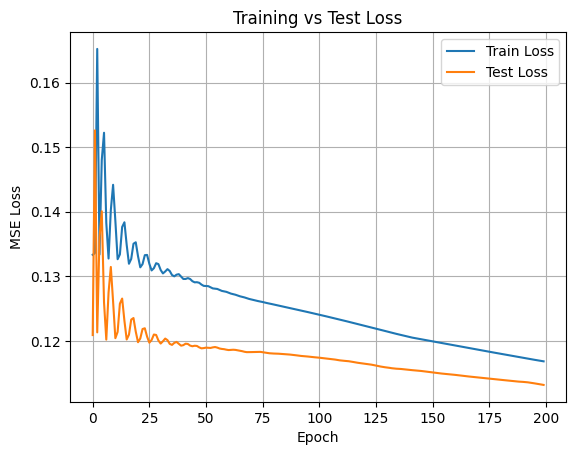

In [8]:
# Plot Losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.grid()
plt.show()

Test New System To see if we just memorized the data rather than learned the function

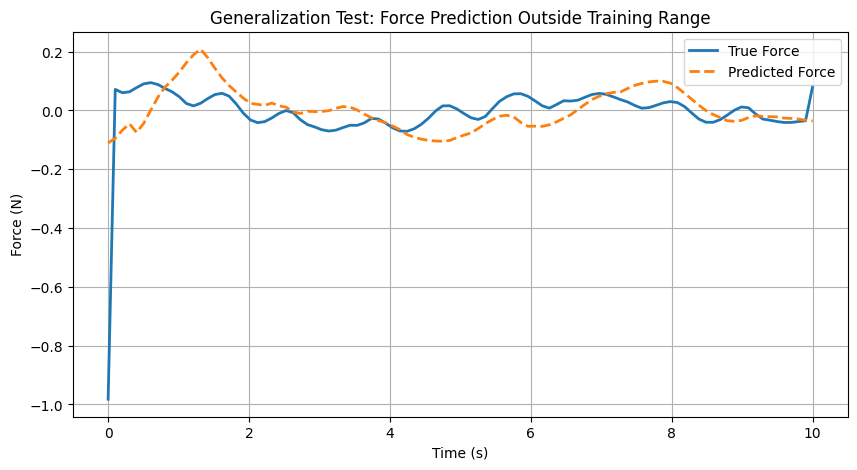

Generalization Test MSE: 0.012382


In [11]:
# --- Step 1: Simulate a NEW system (outside training range) ---
def simulate_new_system(m_test, c_test, k_test, x0=0.0, v0=0.0, t_final=10.0, num_points=100):
    def msd(t, y):
        x, v = y
        dxdt = v
        dvdt = (-c_test * v - k_test * x) / m_test
        return [dxdt, dvdt]

    t_span = (0, t_final)
    t_eval = np.linspace(t_span[0], t_span[1], num_points)
    
    # Set initial conditions (now configurable)
    initial_conditions = [x0, v0]

    # Solve the ODE
    sol = solve_ivp(msd, t_span, initial_conditions, t_eval=t_eval)

    x = sol.y[0]
    v = sol.y[1]
    a = np.gradient(v, t_eval)  # Approximate acceleration from velocity and time

    # True force calculation
    F_true = m_test * a + c_test * v + k_test * x
    # m_test * a +
    return x, v, F_true, t_eval

# --- Step 2: Define NEW parameters ---
m_test = 8.0   # Mass outside training range
c_test = 1.3   # Damping outside training range
k_test = 8.0  # Spring constant outside training range
x0_test = 4.8  # Start at 1 meter displacement
v0_test = 3.5  # Start with 0.5 m/s initial velocity

# --- Step 3: Simulate ---
x_test, v_test, F_true_test, t_eval_test = simulate_new_system(m_test, c_test, k_test, x0=x0_test, v0=v0_test)

a_test = np.gradient(v_test, t_eval_test)  # estimate acceleration

# --- Step 4: Prepare inputs for the trained model ---
X_test_new = np.stack([
    np.full_like(x_test, m_test),  # mass
    np.full_like(x_test, c_test),  # damping
    np.full_like(x_test, k_test),  # spring
    x_test,                        # position
    v_test,                        # velocity
    a_test                         # acceleration
], axis=1)  # Shape: [N, 6] ✅ matches model

X_test_new_tensor = torch.tensor(X_test_new, dtype=torch.float32)

# --- Step 5: Predict forces with the model ---
model.eval()
with torch.no_grad():
    F_pred_test = model(X_test_new_tensor).squeeze().numpy()

# --- Step 6: Plot True vs Predicted ---
plt.figure(figsize=(10,5))
plt.plot(t_eval_test, F_true_test, label='True Force', linewidth=2)
plt.plot(t_eval_test, F_pred_test, '--', label='Predicted Force', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Generalization Test: Force Prediction Outside Training Range')
plt.legend()
plt.grid()
plt.show()

# --- Step 7: Optional: Print MSE
from sklearn.metrics import mean_squared_error
mse_test_outside = mean_squared_error(F_true_test, F_pred_test)
print(f"Generalization Test MSE: {mse_test_outside:.6f}")
